In [1]:
# -----------------------------
# 1. Install Required Libraries
# -----------------------------
%pip install xgboost pulp matplotlib pandas scikit-learn -q


Note: you may need to restart the kernel to use updated packages.


In [10]:
# -----------------------------
# 2. Import Libraries
# -----------------------------
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from pulp import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown

In [11]:
# -----------------------------
# 3. Load and Prepare Data
# -----------------------------
df = pd.read_csv("LD2011_2014.txt", sep=";", index_col=0, parse_dates=True, decimal=',')
df = df.resample('1h').mean()
df['total_load'] = df.sum(axis=1)
df = df[['total_load']].dropna()
df['hour'] = df.index.hour
df['day'] = (df.index - df.index.min()).days
df = df.reset_index()


In [13]:
# -----------------------------
# 4. Train XGBoost Model
# -----------------------------
# Filter to first 60 days
df_train = df[df['day'] < 60].copy()

# Scale total_load to simulate realistic price per kWh ($0.10 – $0.25)
load_min = df_train['total_load'].min()
load_max = df_train['total_load'].max()
df_train['simulated_price'] = 0.10 + 0.15 * ((df_train['total_load'] - load_min) / (load_max - load_min))

# Prepare features and targets
X = df_train[['day', 'hour']]
y = df_train['simulated_price']

# Train/test split and model training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [14]:
# -----------------------------
# 5. Predict Next 6 Hours
# -----------------------------
future_hours = np.array([18, 19, 20, 21, 22, 23])
future_day = np.full_like(future_hours, 61)
future_X = pd.DataFrame({'day': future_day, 'hour': future_hours})
predicted_prices = model.predict(future_X)

In [15]:
# -----------------------------
# 6. User Inputs (Adjustable)
# -----------------------------
battery_capacity = 60       # kWh
current_charge = 20         # kWh
charging_rate = 7.2         # kW/hour
battery_health_mode = True  # Limit to 80% if True

available_hours = list(range(18, 24))
target_charge = battery_capacity * (0.80 if battery_health_mode else 1.0)
needed_charge = max(0, target_charge - current_charge)


In [16]:
# -----------------------------
# 7. Optimization with PuLP
# -----------------------------
charge_vars = LpVariable.dicts("ChargeAtHour", available_hours, 0, 1, cat='Continuous')
prob = LpProblem("EVChargingOptimization", LpMinimize)

prob += lpSum([charge_vars[h] * charging_rate * predicted_prices[i] for i, h in enumerate(available_hours)])
prob += lpSum([charge_vars[h] * charging_rate for h in available_hours]) >= needed_charge
prob.solve()

1

In [17]:
# -----------------------------
# 8. Output Results
# -----------------------------
charging_schedule = {h: charge_vars[h].varValue for h in available_hours}
total_energy = sum(charging_schedule[h] * charging_rate for h in available_hours)
final_charge = current_charge + total_energy
total_cost = sum(charging_schedule[h] * charging_rate * predicted_prices[i] for i, h in enumerate(available_hours))
score = 100 if final_charge <= battery_capacity * 0.80 else 80 if final_charge <= battery_capacity * 0.90 else 60
co2_saved = total_energy * 0.5  # kg CO₂ saved

# Print results
display(Markdown("### ⚡ Optimized Charging Schedule"))
for h in available_hours:
    if charging_schedule[h] > 0:
        display(Markdown(f"- **{h}:00** → Charge for **{charging_schedule[h]:.2f} hour(s)**"))

display(Markdown(f"**🔋 Final Battery Charge:** `{final_charge:.2f} kWh`"))
display(Markdown(f"**💰 Total Charging Cost (proxy):** `${total_cost:.2f}`"))
display(Markdown(f"**🔋 Battery Health Score:** `{score}/100`"))
display(Markdown(f"**🌍 CO₂ Saved:** `{co2_saved:.2f} kg`"))


### ⚡ Optimized Charging Schedule

- **18:00** → Charge for **0.89 hour(s)**

- **21:00** → Charge for **1.00 hour(s)**

- **22:00** → Charge for **1.00 hour(s)**

- **23:00** → Charge for **1.00 hour(s)**

**🔋 Final Battery Charge:** `48.00 kWh`

**💰 Total Charging Cost (proxy):** `$5.69`

**🔋 Battery Health Score:** `80/100`

**🌍 CO₂ Saved:** `14.00 kg`

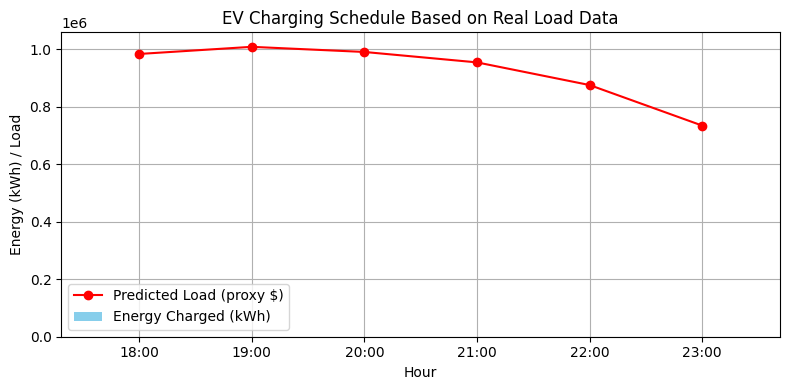

In [8]:
# -----------------------------
# 9. Plot Charging Plan
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 4))
bars = [charging_schedule[h] * charging_rate for h in available_hours]
price_trend = [p * charging_rate for p in predicted_prices]

ax.bar([f"{h}:00" for h in available_hours], bars, color='skyblue', label='Energy Charged (kWh)')
ax.plot([f"{h}:00" for h in available_hours], price_trend, color='red', marker='o', label='Predicted Load (proxy $)')
ax.set_title("EV Charging Schedule Based on Real Load Data")
ax.set_xlabel("Hour")
ax.set_ylabel("Energy (kWh) / Load")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()
